In [18]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('./ml-fairness-gym'))
if module_path not in sys.path:
    sys.path.append(module_path)

from environments import infectious_disease as id
from experiments import infectious_disease as ide
from agents import infectious_disease_agents as ida
import util

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "grid", "notebook"])
# plt.style.use("default")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Params(transition_matrix=array([[0. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ]]), treatment_transition_matrix=array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]]), state_names=['susceptible', 'infected', 'recovered'], healthy_index=0, infectious_index=1, healthy_exit_index=1, infection_probability=0.5, population_graph=<networkx.classes.graph.Graph object at 0x7f0793eb1df0>, initial_health_state=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], initial_health_state_seed=27, num_treatments=1, max_treatments=1, burn_in=0)


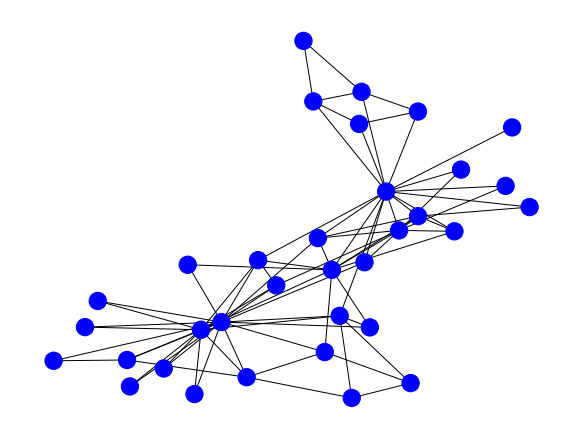

In [22]:
SEED = 13

np.random.seed(SEED)

TAU   = 0.5
RHO   = 0.5
#ide.GRAPHS["scale"] = nx.generators.random_internet_as_graph(100)
# ide.GRAPHS["scale"] = nx.Graph(nx.generators.scale_free_graph(250, seed=SEED).to_undirected())
# G = ide.GRAPHS["scale"]
# G.remove_edges_from(nx.selfloop_edges(G))

EXP = ide.Experiment()
EXP.graph_name = "karate"
EXP.infection_probability     = TAU
EXP.infected_exit_probability = RHO
EXP.num_treatments = 1
EXP.burn_in = 0
EXP.agent_constructor = ide.NullAgent
EXP.scenario_builder()
print(EXP.env.initial_params)

positions = nx.spring_layout(EXP.env.initial_params.population_graph, seed=SEED)
color_map = ["blue", "red", "purple"]
EXP.env.render(color_map, pos=positions)

In [3]:
EXP.num_steps = 20
N = 1000

EXP.agent_constructor = ide.NullAgent
null_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ide.RandomAgent
rng_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ida.RandomNeighborAgent
rnn_metrics = util.run_simulations(N, EXP)

EXP.agent_constructor = ida.PrecisionRandomAgent
prr_metrics = util.run_simulations(N, EXP)

100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


In [4]:
EXP.agent_constructor = ida.CentralityAgent
ida.CENTRALITY_FUNCION = nx.centrality.eigenvector_centrality
eig_metrics = util.run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.degree_centrality
deg_metrics = util.run_simulations(N, EXP)

ida.CENTRALITY_FUNCION = nx.centrality.betweenness_centrality
btw_metrics = util.run_simulations(N, EXP)

100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]


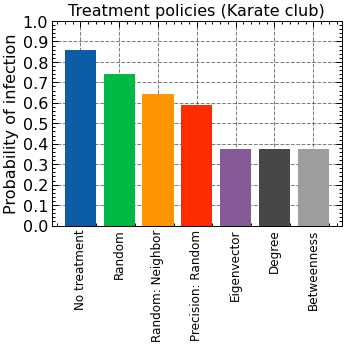

In [145]:
metrics = [null_metrics, rng_metrics, rnn_metrics, prr_metrics, eig_metrics, deg_metrics, btw_metrics]
labels = ["No treatment", "Random", "Random: Neighbor", "Precision: Random", "Eigenvector", "Degree", "Betweenness"]

plt.figure(figsize=(5, 5))
plt.title("Treatment policies (Karate club)")
plt.ylabel("Probability of infection")
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(bottom=0.0, top=1.0)
plt.tick_params(axis="x", labelsize=12)
for metric, label in zip(metrics, labels):
    plt.bar(label, np.mean(metric["num_sickdays"]) / N)
plt.tight_layout()
plt.savefig("out/nb-karate-sickdays.jpg")
plt.show()

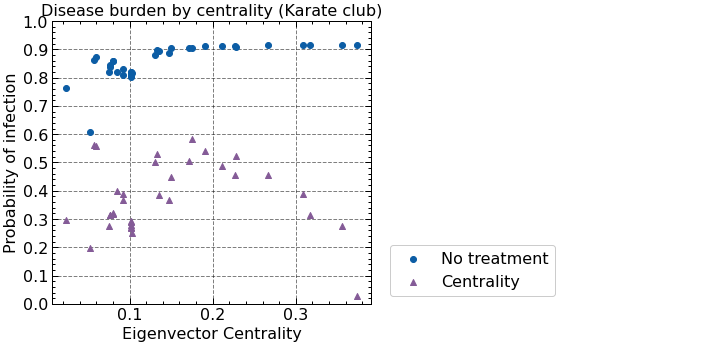

In [146]:
G = ide.GRAPHS["karate"]
# deg_cent = nx.centrality.degree_centrality(G).values()
eig_cent = nx.centrality.eigenvector_centrality(G).values()
# btw_cent = nx.centrality.betweenness_centrality(G).values()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_title("Disease burden by centrality (Karate club)")
ax[0].set_ylabel("Probability of infection")
ax[0].set_xlabel("Eigenvector Centrality")
ax[0].set_ylim(bottom=0.0, top=1.0)
ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
ax[0].scatter(eig_cent, null_metrics["num_sickdays"] / N, label="No treatment")
ax[0].scatter(eig_cent, rng_metrics["num_sickdays"] / N, alpha=0)
ax[0].scatter(eig_cent, rnn_metrics["num_sickdays"] / N, alpha=0)
ax[0].scatter(eig_cent, prr_metrics["num_sickdays"] / N, alpha=0)
ax[0].scatter(eig_cent, eig_metrics["num_sickdays"] / N, label="Centrality", marker="^")

ax[1].axis("off")
h, l = ax[0].get_legend_handles_labels()
ax[1].legend(h, l, loc="lower left")
# plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
fig.tight_layout()
fig.savefig("out/nb-karate-centrality-1.jpg")
# plt.show()

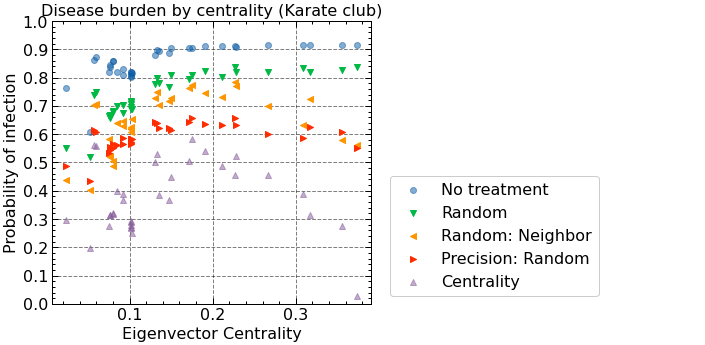

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_title("Disease burden by centrality (Karate club)")
ax[0].set_ylabel("Probability of infection")
ax[0].set_xlabel("Eigenvector Centrality")
ax[0].set_ylim(bottom=0.0, top=1.0)
ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
ax[0].scatter(eig_cent, null_metrics["num_sickdays"] / N, label="No treatment", alpha=0.5)
ax[0].scatter(eig_cent, rng_metrics["num_sickdays"] / N, label="Random", marker="v")
ax[0].scatter(eig_cent, rnn_metrics["num_sickdays"] / N, label="Random: Neighbor", marker="<")
ax[0].scatter(eig_cent, prr_metrics["num_sickdays"] / N, label="Precision: Random", marker=">")
ax[0].scatter(eig_cent, eig_metrics["num_sickdays"] / N, label="Centrality", marker="^", alpha=0.5)

ax[1].axis("off")
handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles, labels, loc="lower left")
# plt.legend(bbox_to_anchor=(1, 0), loc="lower left")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
fig.tight_layout()
fig.savefig("out/nb-karate-centrality-2.jpg")
# fig.show()

In [98]:
G = ide.GRAPHS["karate"]
comms = nx.community.girvan_newman(G)
comms = next(comms)
comm1 = np.array(list(comms[0]))
comm2 = np.array(list(comms[1]))

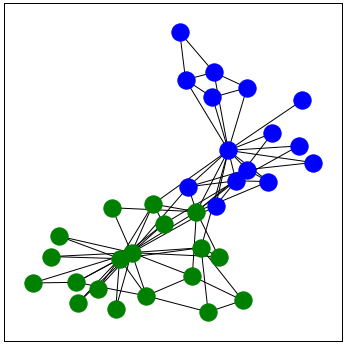

In [141]:
plt.figure(figsize=(5, 5))
plt.grid(False)
plt.tick_params(axis="x", which="both", top=False)
plt.tick_params(axis="y", which="both", right=False)
nx.draw_networkx_nodes(G, positions, nodelist=comms[0], node_color="blue")
nx.draw_networkx_nodes(G, positions, nodelist=comms[1], node_color="green")
nx.draw_networkx_edges(G, positions)
plt.tight_layout()
plt.savefig("out/nb-karate-groups.jpg")
plt.show()

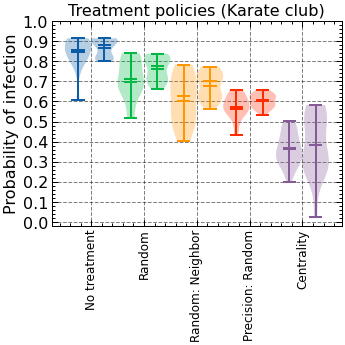

In [148]:
plt.figure(figsize=(5, 5))
plt.title("Treatment policies (Karate club)")
plt.ylabel("Probability of infection")
for i, metric in enumerate(metrics[:5]):
    d = [metric["num_sickdays"][comm1] / N, metric["num_sickdays"][comm2] / N]
    plt.violinplot(d, [i + 1, i + 1.5], showmedians=True, showmeans=True)
plt.xticks(ticks=[1.25, 2.25, 3.25, 4.25, 5.25], labels=labels[:5], rotation=90)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.tick_params(axis="x", labelsize=12)
plt.tight_layout()
plt.savefig("out/nb-karate-groups-plot.jpg")
plt.show()